In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

Epoch 1/10:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.6551, Train Accuracy: 71.72%, Validation Accuracy: 68.54%


Epoch 2/10:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.5314, Train Accuracy: 77.21%, Validation Accuracy: 73.41%


Epoch 3/10:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.4901, Train Accuracy: 78.44%, Validation Accuracy: 73.17%


Epoch 4/10:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.4677, Train Accuracy: 79.60%, Validation Accuracy: 76.34%


Epoch 5/10:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.4358, Train Accuracy: 79.90%, Validation Accuracy: 76.10%


Epoch 6/10:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.4082, Train Accuracy: 82.53%, Validation Accuracy: 78.05%


Epoch 7/10:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.3866, Train Accuracy: 83.69%, Validation Accuracy: 78.05%


Epoch 8/10:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.3710, Train Accuracy: 86.01%, Validation Accuracy: 78.05%


Epoch 9/10:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.3326, Train Accuracy: 87.54%, Validation Accuracy: 79.51%


Epoch 10/10:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.3151, Train Accuracy: 89.55%, Validation Accuracy: 75.85%


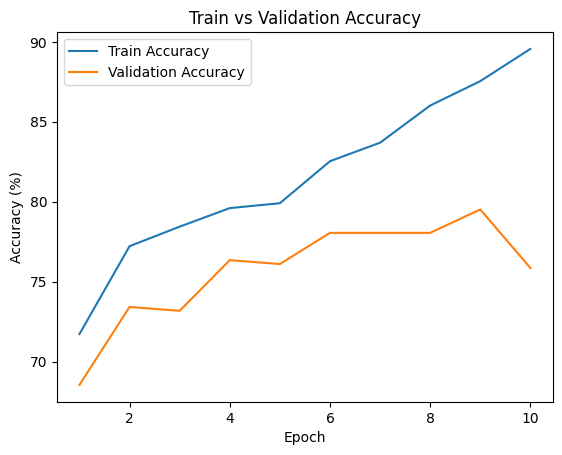

In [2]:
# Define the Hotdog_NotHotdog dataset class
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='C:/Users/nicla/DTU/ComputerVision/1st Poster/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path + '/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

# Define the SimpleCNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.sigmoid(x)

# Set parameters
size = 128
batch_size = 64
train_transform = transforms.Compose([transforms.Resize((size, size)), transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), transforms.ToTensor()])

# Load the train dataset and split it into training and validation sets
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

# Create DataLoaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

# Initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            predicted = (outputs > 0.5).float().squeeze() 
            total += labels.size(0)
            correct += (predicted == labels.float()).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Training loop
num_epochs = 10
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for i, data in enumerate(progress_bar):
        inputs, labels = data
        optimizer.zero_grad() 

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track the loss
        running_loss += loss.item()
        progress_bar.set_postfix({'Loss': running_loss / (i+1)})

    # Calculate train and validation accuracy
    train_acc = calculate_accuracy(train_loader, model)
    val_acc = calculate_accuracy(val_loader, model)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, '
          f'Train Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%')

# Plot train and validation accuracy
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Train vs Validation Accuracy')
plt.show()